In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz
import utils.segs_viz as segs_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args
    
def downsample_affinities(affs, size, downsample_factor=2):
    affs = affs.view(1, size[0]*size[1], size[0], size[1])
    ds = downsample_factor
    N = size[0]*size[1]
    N_out = N // (ds**2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,size[0],size[1],-1).permute(0,3,1,2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,N_out,N_out).transpose(1,2)
    return affs    
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load some TDW preds and gt

In [106]:
results_dir = '/mnt/fs6/honglinc/eccv_2022_results/'
os.listdir(results_dir)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['TDW_Cylinder_MaskRCNN_RAFT',
 'TDW_MaskRCNN_Full',
 'TDW_Safari_EISEN_RAFT',
 'TDW_Cylinder_EISEN_RAFT',
 'TDW_Safari_MaskRCNN_RAFT',
 'TDW_MaskRCNN_RAFT',
 'TDW_EISEN_RAFT']

In [123]:
# results_path = os.path.join(results_dir, 'TDW_MaskRCNN_RAFT')
results_path = os.path.join(results_dir, 'TDW_EISEN_RAFT')
results = sorted(os.listdir(results_path))
results[0:5]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['model_split_0-0009.pt',
 'model_split_0-0019.pt',
 'model_split_0-0029.pt',
 'model_split_0-0039.pt',
 'model_split_0-0049.pt']

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


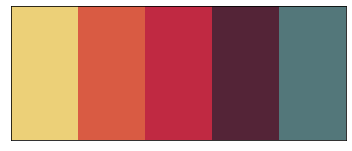

In [94]:
segs_viz.plot_palette(i=2)

## Compare EISEN to a baseline

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


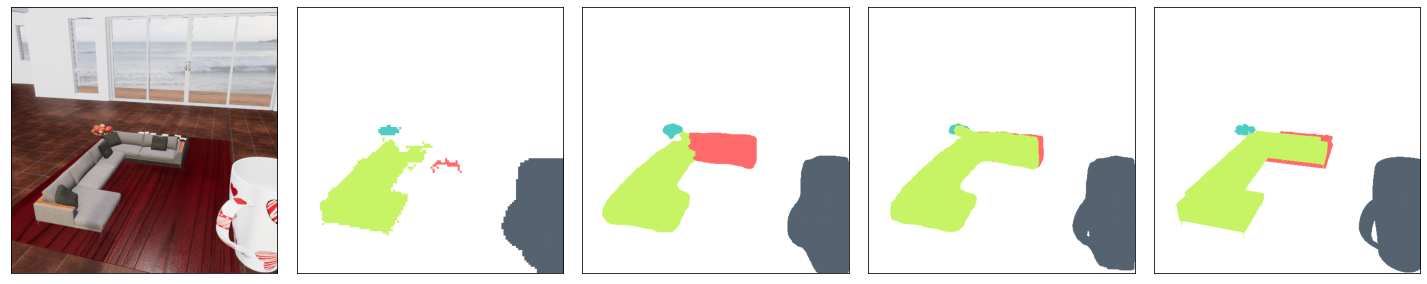

  0%|          | 0/3 [00:00<?, ?it/s]

0 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0009.svg



100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


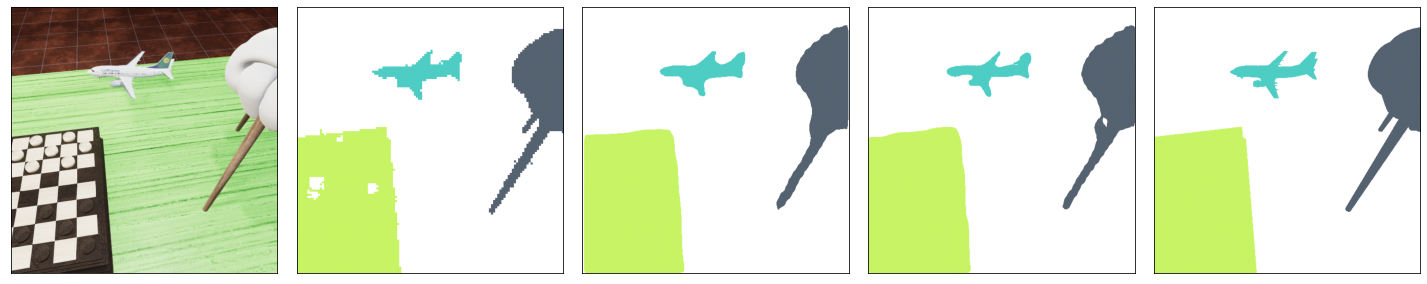

  0%|          | 0/3 [00:00<?, ?it/s]

1 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0019.svg



100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


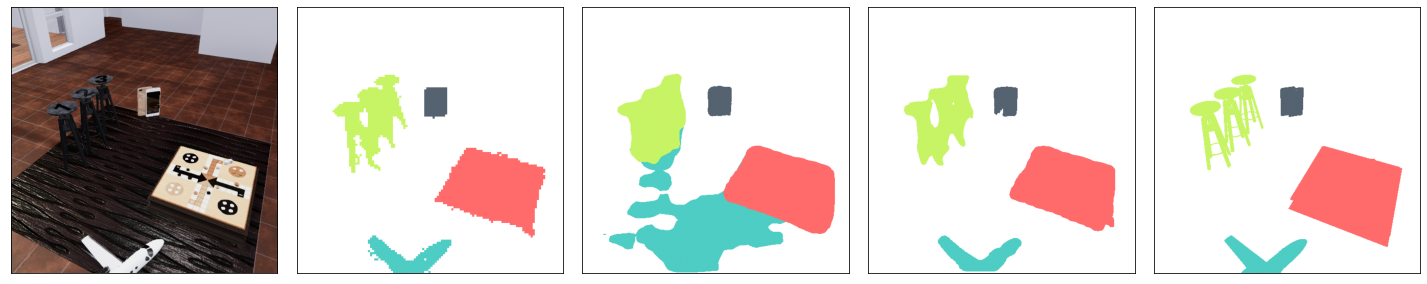

  0%|          | 0/3 [00:00<?, ?it/s]

2 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0029.svg



100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


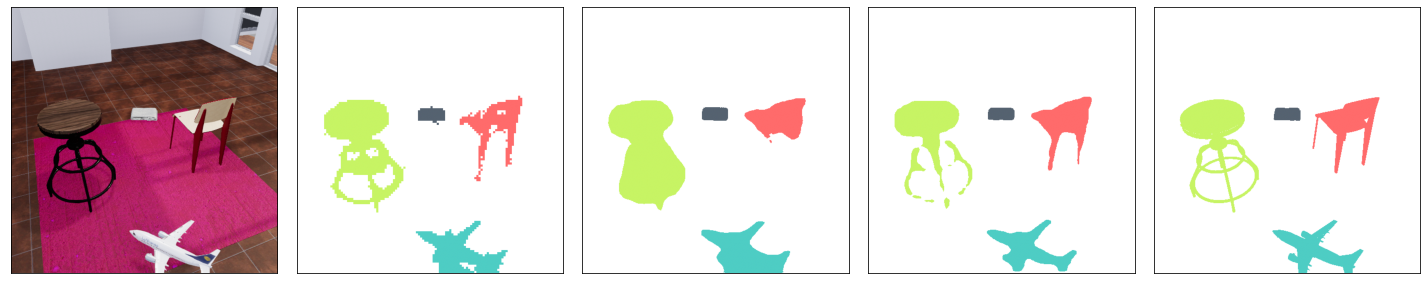

  0%|          | 0/3 [00:00<?, ?it/s]

3 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0039.svg



100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


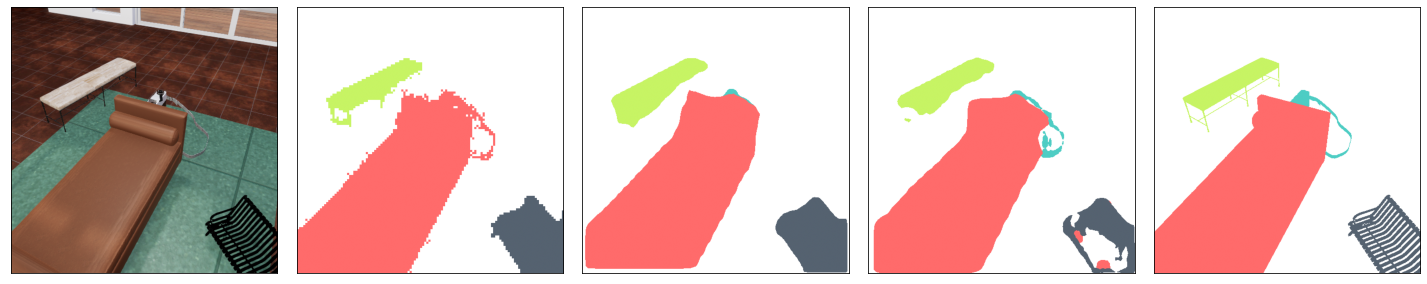

  0%|          | 0/3 [00:00<?, ?it/s]

4 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0049.svg



100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


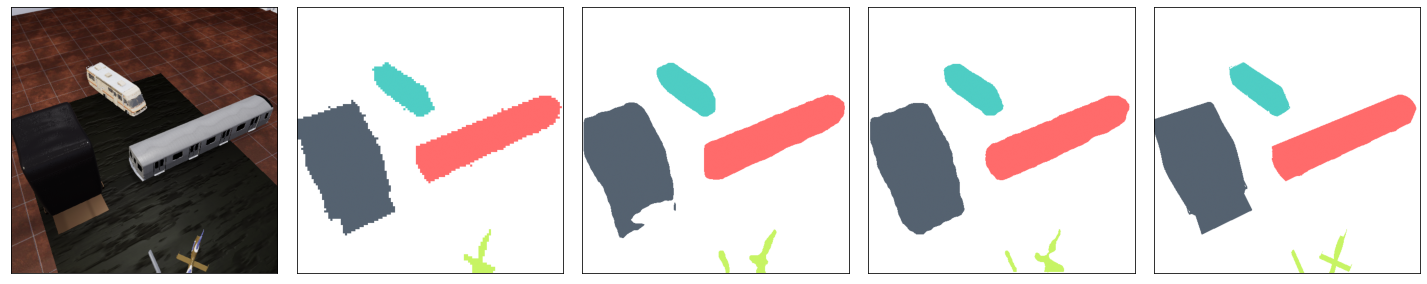

  0%|          | 0/3 [00:00<?, ?it/s]

5 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0059.svg



100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


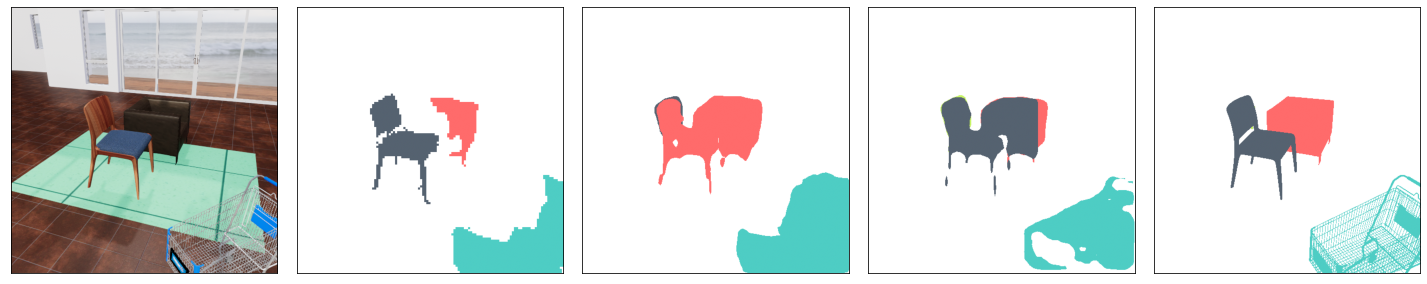

  0%|          | 0/3 [00:00<?, ?it/s]

6 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0069.svg



100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


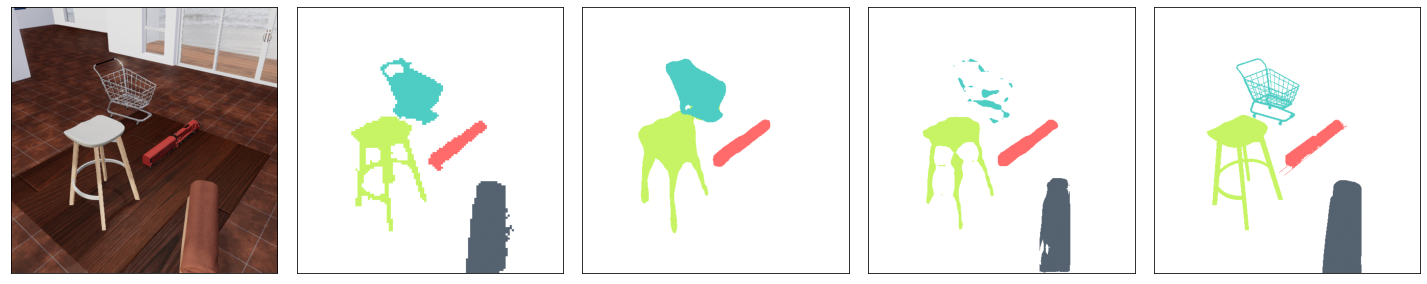

  0%|          | 0/3 [00:00<?, ?it/s]

7 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0079.svg



100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


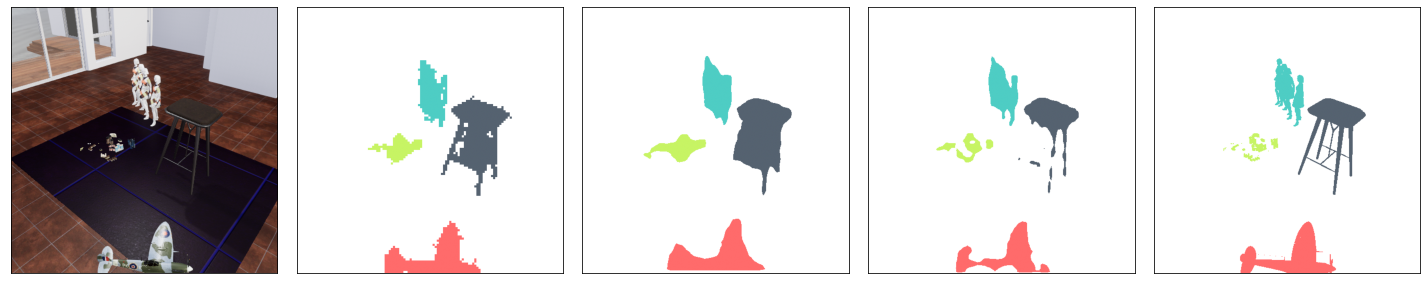

  0%|          | 0/3 [00:00<?, ?it/s]

8 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0089.svg



100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


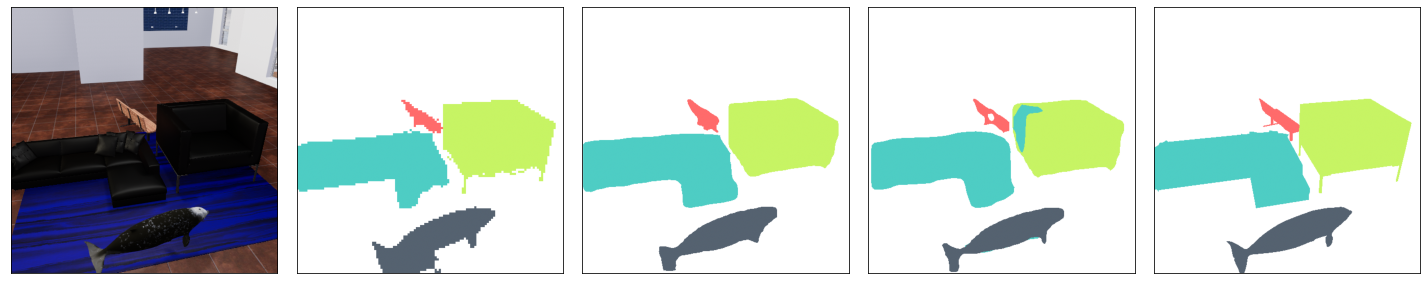

  0%|          | 0/3 [00:00<?, ?it/s]

9 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0099.svg



100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


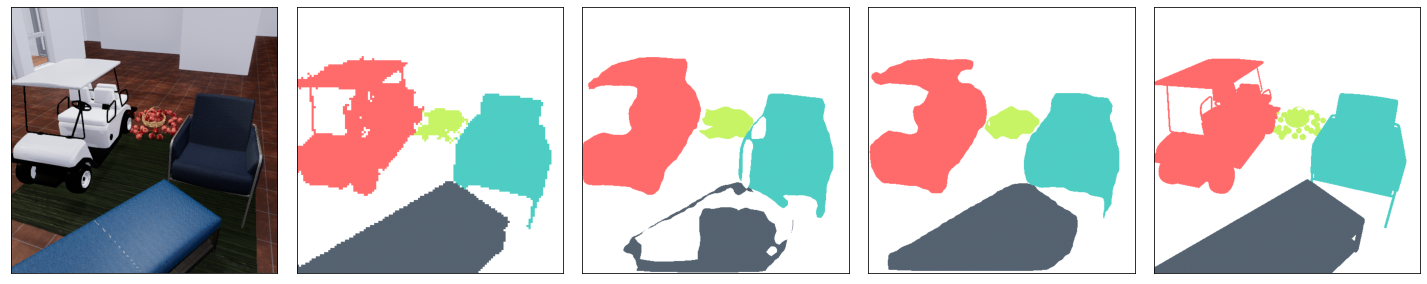

  0%|          | 0/3 [00:00<?, ?it/s]

10 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0109.svg



100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


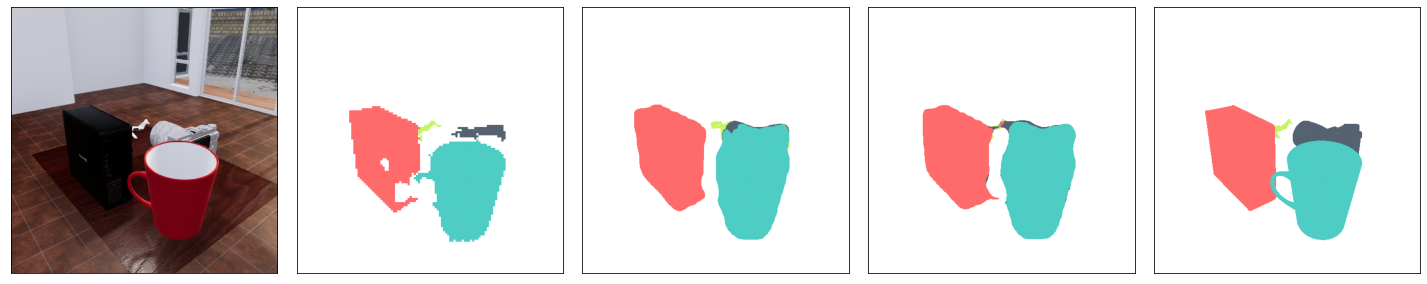

  0%|          | 0/3 [00:00<?, ?it/s]

11 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0119.svg



100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


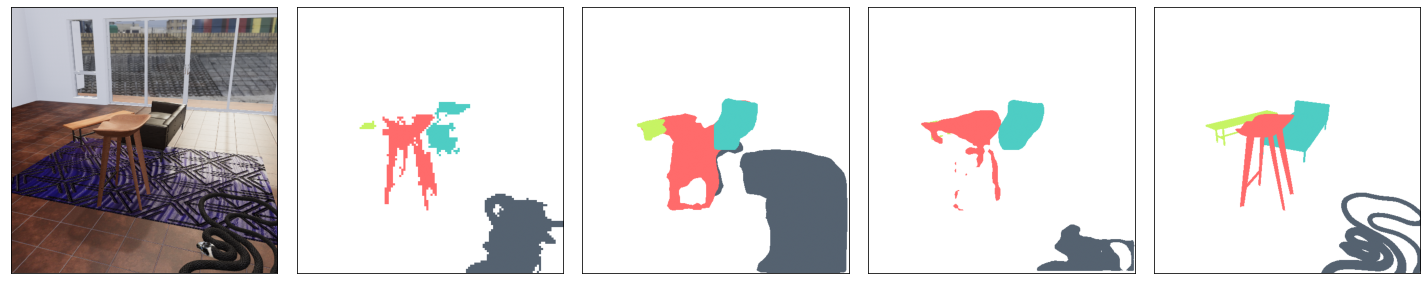

  0%|          | 0/3 [00:00<?, ?it/s]

12 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0129.svg



100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


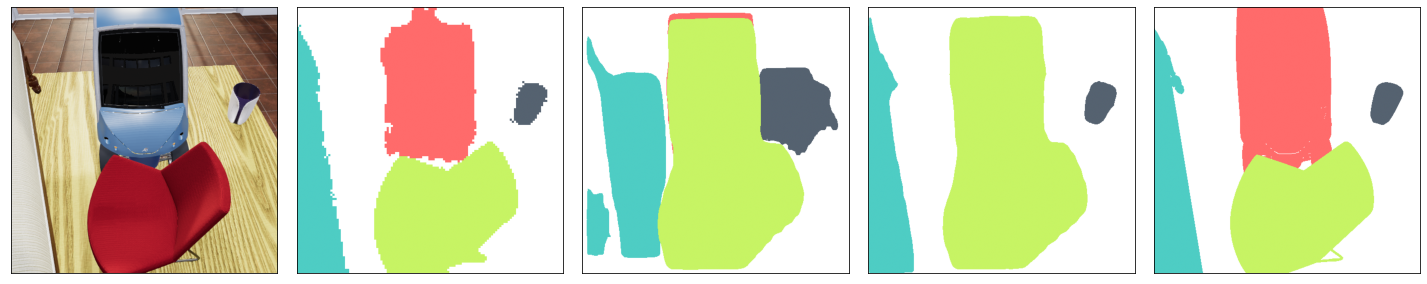

  0%|          | 0/3 [00:00<?, ?it/s]

13 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0139.svg



100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


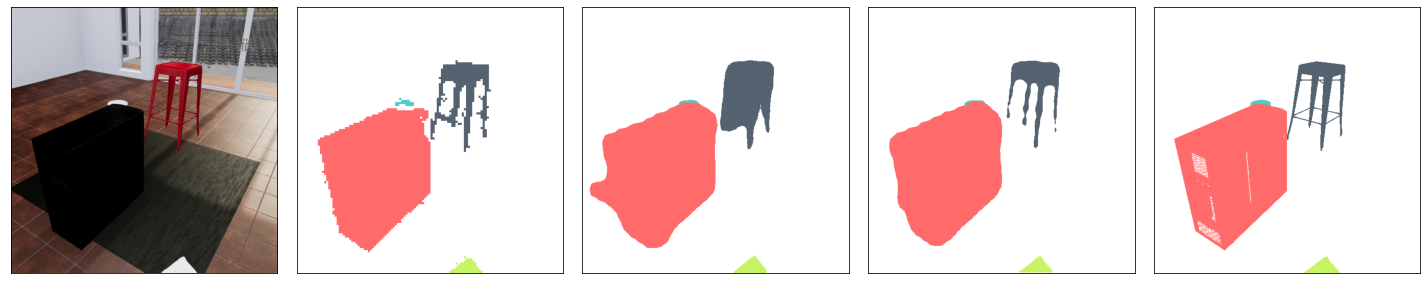

  0%|          | 0/3 [00:00<?, ?it/s]

14 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0149.svg



100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


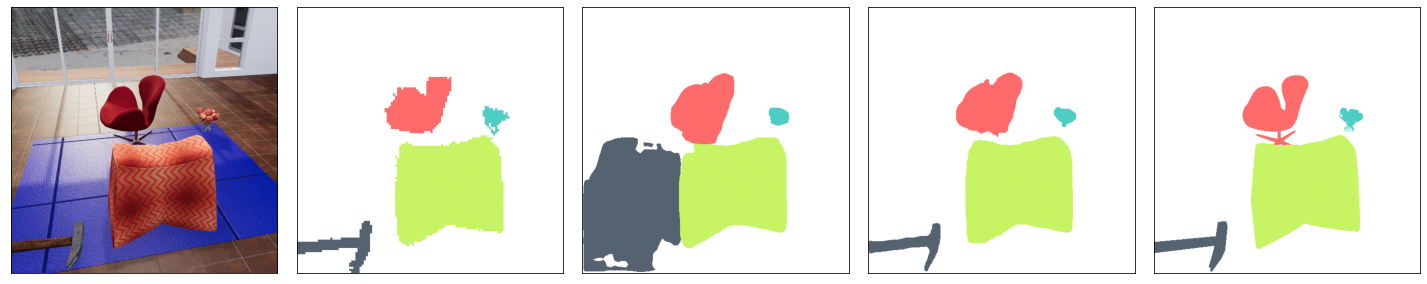

  0%|          | 0/3 [00:00<?, ?it/s]

15 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0159.svg



100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


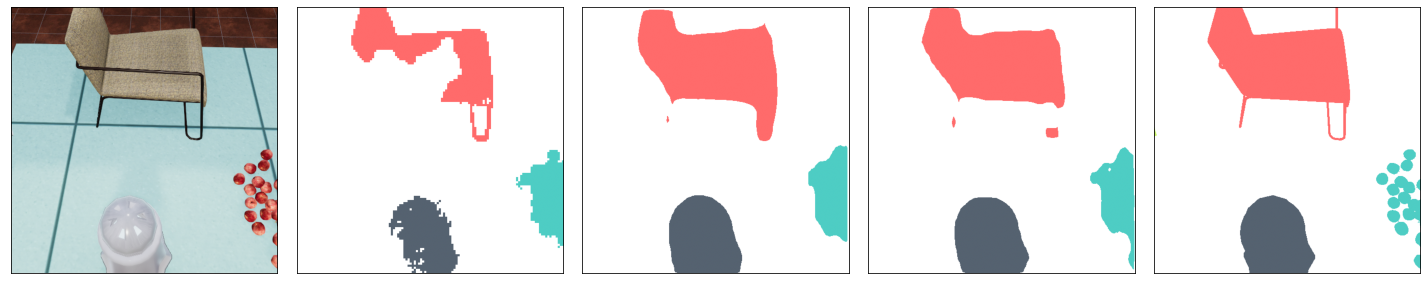

  0%|          | 0/3 [00:00<?, ?it/s]

16 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0169.svg



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


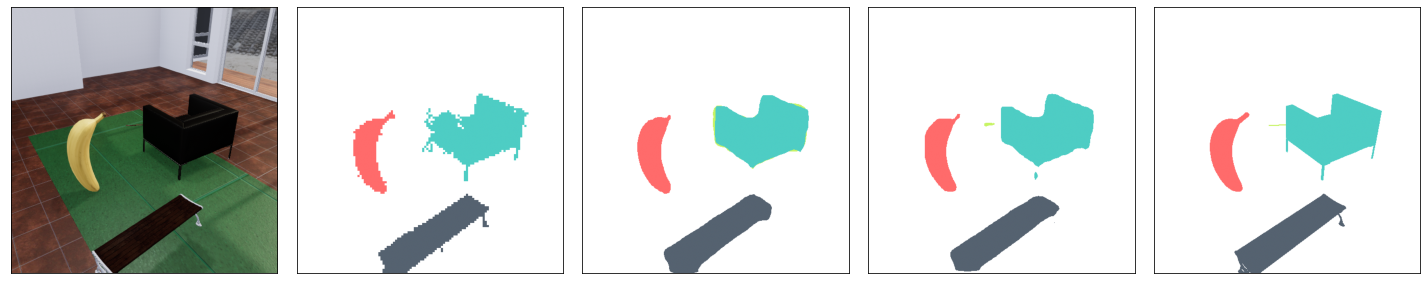

  0%|          | 0/3 [00:00<?, ?it/s]

17 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0179.svg



100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


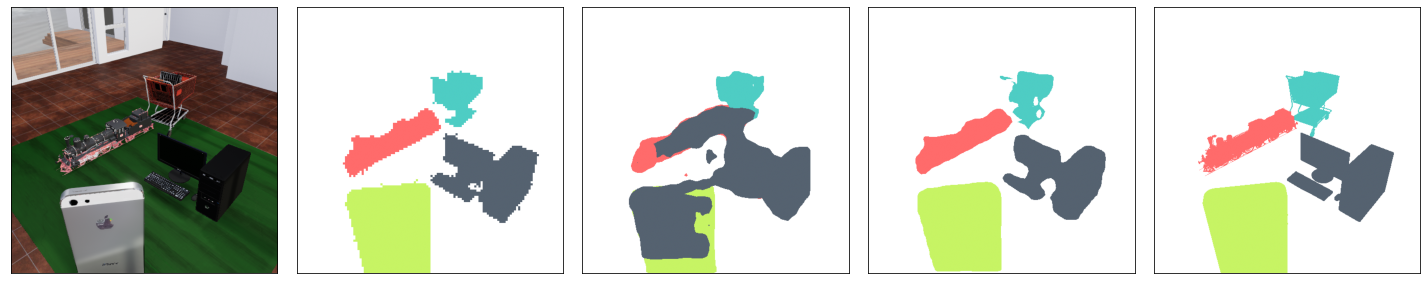

  0%|          | 0/3 [00:00<?, ?it/s]

18 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0189.svg



100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


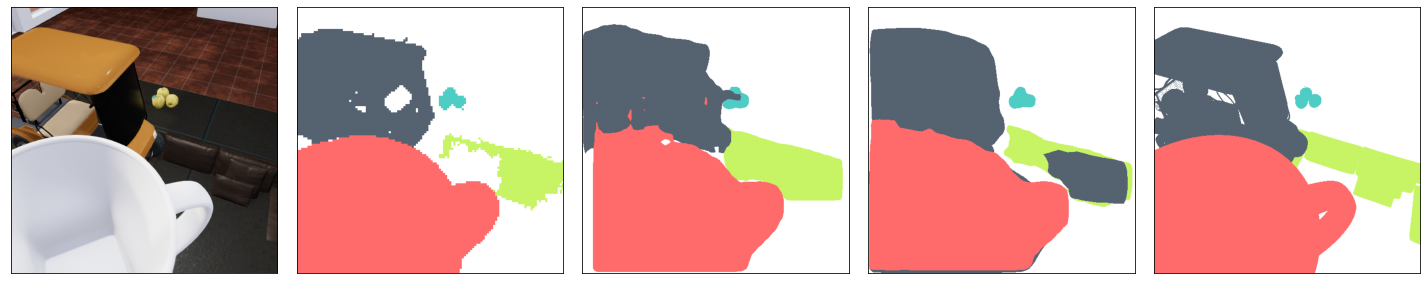

100%|██████████| 20/20 [00:54<00:00,  2.71s/it]

19 TDW_val_EISEN_RAFT_MaskRCNN_RAFT_MaskRCNN_Full_model_split_0-0199.svg


In [159]:
cmap = 3 # use one of the new palettes
models = ['TDW_EISEN_RAFT', 'TDW_MaskRCNN_RAFT', 'TDW_MaskRCNN_Full']


save_dir = '/mnt/fs6/dbear/eccv_2022_results/figures'
fig_dir = 'eisen_vs_baseline_tdw'
eval_set = 'TDW_val'
save_prefix = eval_set + '_' + '_'.join(['_'.join(m.split('_')[-2:]) for m in models]) + '_'

for ex in tqdm(range(20)):
    save_name =  save_prefix + results[ex].split('.')[0] + '.svg'
    out = segs_viz.compare_models(results_dir, models, ex=ex, cmap=cmap,
                                  show_titles=False,
                                  save_path=os.path.join(save_dir, fig_dir, save_name)
                                 )
    print(ex, save_name)